In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as scs

np.random.seed(42)

%config InlineBackend.figure_format = 'retina'

# Model Selection and Tuning Strategies
## or: Bias-Variance and Cross-Validation

Lecture by Brandon Martin-Anderson, master of Media Arts and Sciences, based on the lecture of Mark Llorente PhD, based on the work of Ryan Henning

## Review: "Model"

What is a model? (question to the class)

In truth we've been using the word informally, as, sort of, "usefully simplified version of some complicated thing".

* The earth is modeled as a sphere. (Though it's lumpy.)
* Space is modeled as a vacuum. (Though it's full of charged particles.)
* Human height is modeled as a normal distribution. (Though it deviates.)
* House prices are modeled as rising steadily as house size increases. (Plainly wrong.)


In fact, when we use the word quantitatively, we mean one of two specific things.

### Generative models

These are **joint distributions** of probability over a space of one or more salient properties. For example given two features, $X$ and $Y$, the generative model is a joint distribution

$$P(X, Y)$$

You can represent this as a PDF or PMF in $n$ dimensional space, where $n$ is the number of properties. For example, we might model the joint distribution of pigmy hippo weights and ages from 0 to 4 years old with:

$$x_{age} \sim U(0,4)$$
$$x_{weight}(x_{age}) \sim N(\mu=10+10x_{age}, \sigma=5x_{age})$$


In [2]:
def get_hippo_weights(n):
    age = np.random.uniform(0,4, size=n)

    mu = 10+10*age
    sigma = 5*age
    weight = np.random.normal(loc=mu, scale=sigma)
    
    return np.stack([age,weight]).round(4)

In [3]:
age, weight = get_hippo_weights(10000)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(27.125, 0.5, 'Weight')

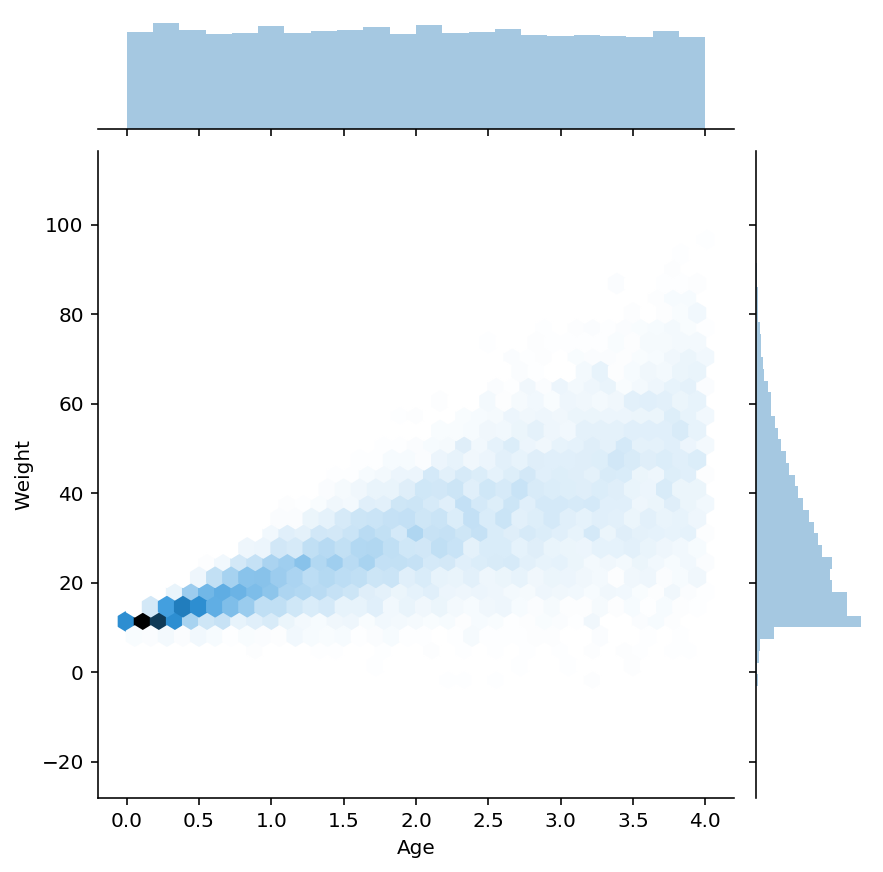

In [4]:
ax = sns.jointplot(age, weight, kind="hex")
ax.ax_joint.set_xlabel("Age")
ax.ax_joint.set_ylabel("Weight")

"Fitting" a generative model means to estimate model parameters to get as close as possible to population parameters. Because we rarely have access to the population - only samples made from it - a common strategy for model fitting is to pick parameters that maximize the model's probability for all observed data.

## Discriminative (aka "Predictive") models

A predictive model is a **conditional** distribution of one feature given another:

$$P(Y | X=x)$$

For example we might be curious about the distribution of pygmy hippo weights given a certain age:

$$P(weight | age)$$.

You can think of this as "predicting" the weight given the age.

I'm using language very similar to "generative models" (AKA "probability distributions") to emphasize that the goal of "fitting" the model is exactly the same. We want to select a model and parameters that match population parameters, given access to samples from the population.

Likewise, we could use the same strategy as above: select models and parameters that maximize the probability of the data.

So go through an example where we do exactly that.

Here's our data, a sample of 50 hippos:



In [5]:
np.random.seed(3)
age, weight = get_hippo_weights(50)

Text(0, 0.5, 'Hippo Weight')

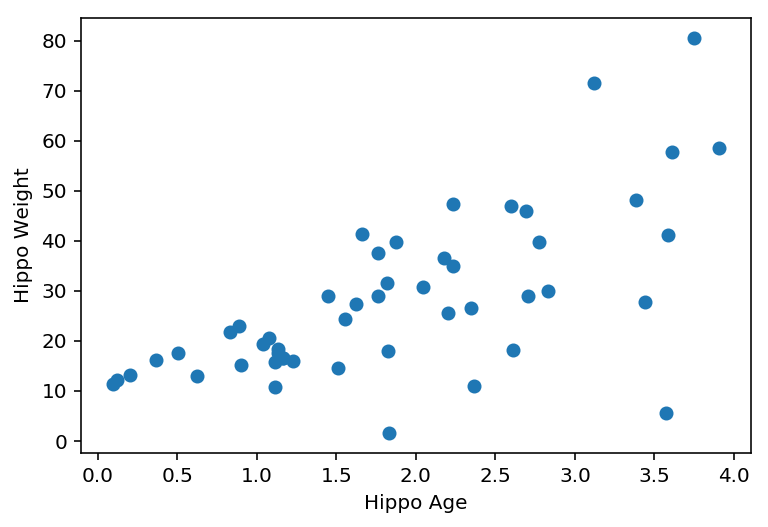

In [6]:
plt.scatter(age, weight)
plt.xlabel("Hippo Age")
plt.ylabel("Hippo Weight")

I want to cook up a model that maximizes its likelihood. One simple hack, a conditional empirical distribution:

In [7]:
class EmpiricalModel:
    def fit(self, X, y):
        self.data = dict(zip([tuple(x) for x in X],y))
        
    def predict(self, x):
        if x in self.data:
            return lambda y: 1 if abs(y-self.data[x])<0.00001 else 0
        else:
            return lambda y: np.nan

In [8]:
model = EmpiricalModel()
model.fit( age.reshape((-1,1)), weight ) #X needs to be 2d

If I call ```model.predict``` it gives me a function, which I can use to find the probability of the target variable (in this case, weight).

In [9]:
P_weight = model.predict( (2.2032,) )

In [10]:
P_weight(25.4592)

1

In [11]:
P_weight(21)

0

Now that I have this model, I can calculate the probability of seeing this dataset:

In [12]:
dataset_prob = 1
for x, y in zip( age.reshape((-1,1)), weight ):
    sample_prob = model.predict( tuple(x) )(y)
    dataset_prob *= sample_prob

In [13]:
dataset_prob

1

I have built a model that basically looks like this:

Text(0.5, 1.0, 'The perfect hippo model(?)')

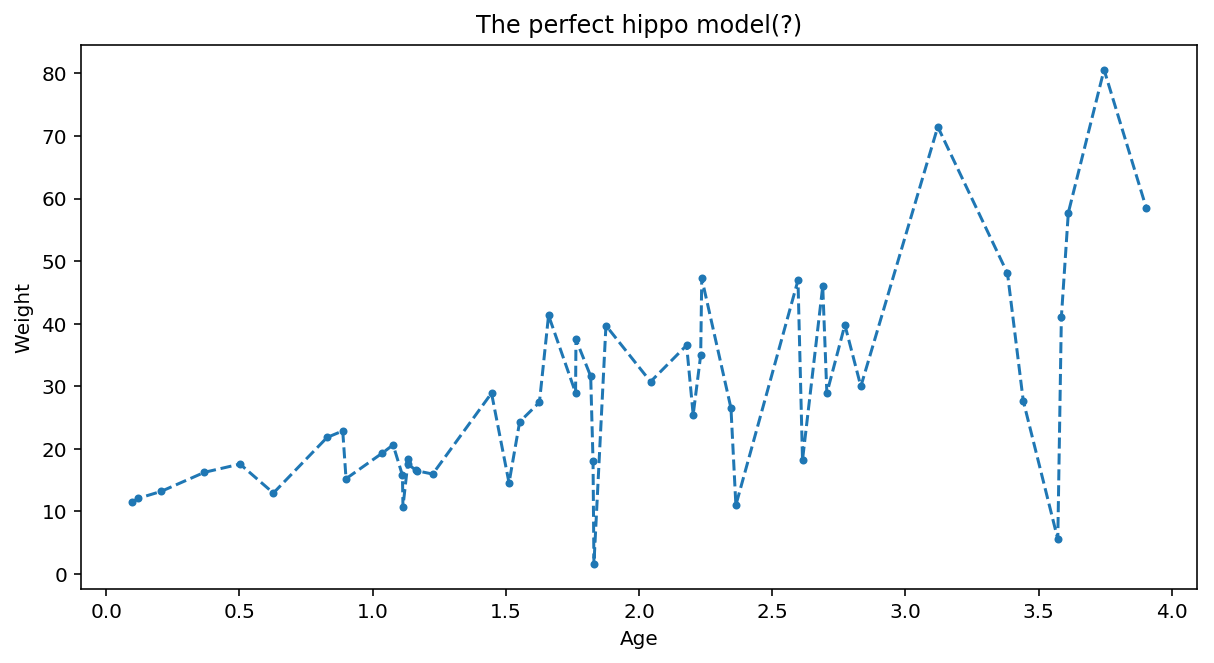

In [14]:
sortorder = np.argsort(age)
plt.figure(figsize=(10,5))
plt.plot(age[sortorder],weight[sortorder], ".--")
plt.xlabel("Age")
plt.ylabel("Weight")
plt.title("The perfect hippo model(?)")

Is this the best hippo model?

For one, if we ask for a conditional probability distribution for a non-observed age, the model just falls on its face:

In [15]:
weight_given_age = model.predict(2.5)
weight_given_age( 40 )

nan

But, in a bigger sense, the tingling you're feeling in your sense of logic has a subtle root. Let's return to our definition of a fit model:

## We want to select a model and parameters that match **population** parameters, given access to **samples** from the population.

The philosophical gravity of this goal is difficult to understate. It's fascinating. It also directly informs **a large fraction** of the practice of machine learning.

* We have to estimate a thing
* But we never get to see it
* If you maximize your model with respect to what you do have access to, you'll do a bad job.

## Intuitive solution: draw a line

By now you're itching to do the obvious thing.

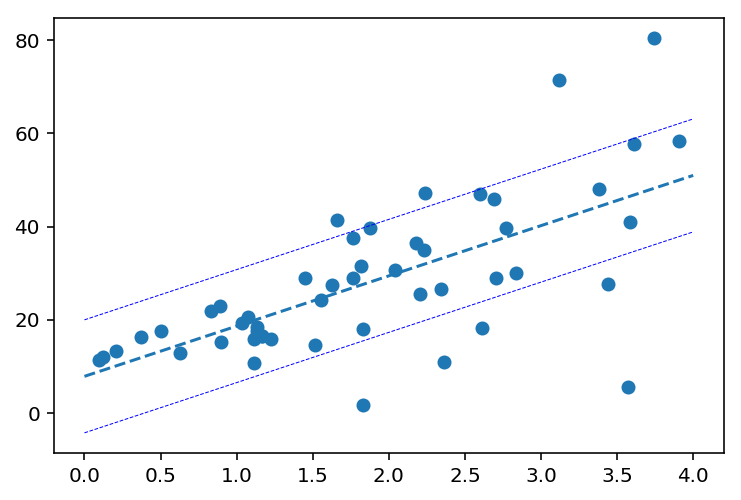

In [16]:
res = scs.linregress(age, weight)

fitline = lambda x:x*res.slope+res.intercept
# estimate the sigma
sigma = (weight-fitline(age)).std()

plt.scatter(age, weight)

x = np.linspace(0,4)
y = fitline(x)
plt.plot(x,y, "--")
plt.plot(x,y-sigma, "b--", lw=0.5, )
plt.plot(x,y+sigma, "b--", lw=0.5, )

In [17]:
class LinearModel:
    def __init__(self, m, b, sigma):
        self.m = m
        self.b = b
        self.sigma = sigma
        
    def predict(self, x):
        return lambda y: scs.norm(loc=self.m*x+self.b, scale=self.sigma).pdf(y)

In [18]:
model = LinearModel(res.slope, res.intercept, sigma)

In [19]:
pdf_weight = [model.predict(x)(y) for x, y in zip(age, weight)]

In [20]:
sample_likelihood = np.product(pdf_weight)
sample_likelihood

9.893536392348948e-86

That's dire. The likelihood of this data w/r/t the linear model is *86 orders of magnitude* worse than the empirical model. Why exactly is it better?

Well, for one, it can handle unseen ages:

In [21]:
weight_given_age = model.predict(2.5)
weight_given_age( 40 )

0.030026117940926453

But how exactly do we know it's better? Because it seems better but has a worse likelihood score. What kinds of strategies could we use to guide our modelling and hyperparameter decisions, when maximum likelihood estimation seems to lie to us?

## Model evaluation in practice

Before we proceed let's consider the above material the way it often appears in practice. I said that a predictive model is the conditional distribution:

$P(Y | X=x)$

It's common to conceptualize this is a function that outputs a distribution:

$f(X) \rightarrow P(Y)$

In practice the distribtion P(Y) is often 1 for a single number and 0 for all other numbers ("the degenerate distribution"). In this common then to see the above as:

$f(X) \rightarrow \hat{y}$

where $\hat{y}$ is a point estimate for given the predictors X.

When the model output is a scalar instead of a distribution, the fitting process is modified to minimize some function of the difference between prediction and baseline output. This ends up being a relatively minor detail, with the 800-pound gorilla of model selection strategy being the concept of

## The Bias-Variance Tradeoff

`Alert` You will *definitely* be asked the definition of these terms in an interview.

**If you remember one thing**

The average square error of a model is the sum of the model **variance**, the model **bias**, and the **irreducible error** of the underlying data.

```err(x) = bias^2 + variance + irreducable_error```

* The **bias** is the tendency of the model to make the wrong prediction.
* The **variance** is the extent to which a model changes when trained with a different sample.
* The **irreducible error** is the minimum possible error achieveable by a model of a given population; it is the result of uncorrelated physical noise.

### Simple example 1: all bias

For example, imagine a population described by $f(x)=2$ every draw from the population is `2`. Also imagine a model $\hat{f}(x) = 1$. 



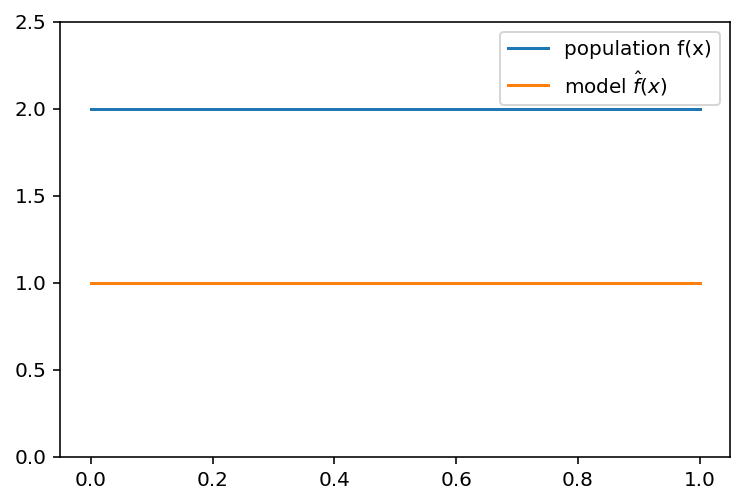

In [22]:
x = np.linspace(0,1)
f = np.ones_like(x)*2
fhat = np.ones_like(x)*1
plt.plot(x,f, label="population f(x)")
plt.plot(x,fhat, label="model $\hat{f}(x)$")
plt.ylim(0,2.5)
plt.legend()

* The prediction is wrong by `1`, so the bias is `1`. 
* The prediction will never vary even when re-trained, so the variance is `0`.
* There is never any noise in draws from the underlying population, so irreducable noise is `0`.
* The square error is $(2-1)^2 = 1$. This is equal to the square bias, plus the variance, plus the noise.

### Simple example 2: maximum variance

Imagine a population described by $f(x) = N(\mu=0, \sigma=1)$, and a model $\hat{f}(x)$ that perfectly fit any sample.

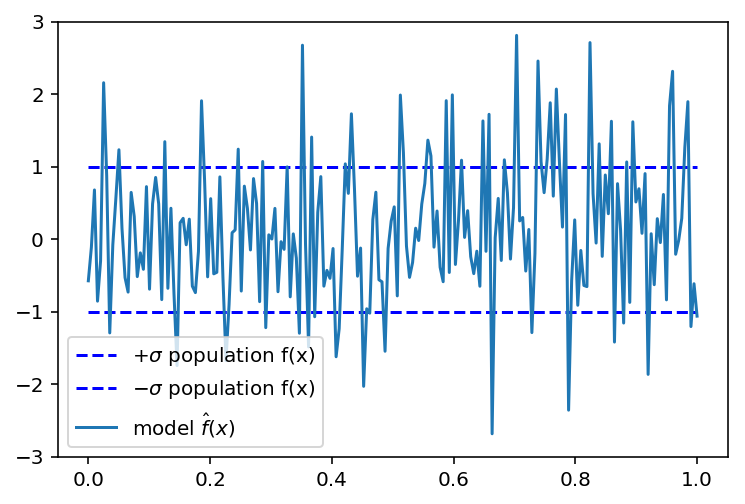

In [23]:
x = np.linspace(0,1,num=200)
f = np.ones_like(x)*1
fhat = np.random.normal(0,1,size=len(x))
plt.plot(x,np.zeros_like(x)+1, "b--", label="$+\sigma$ population f(x)")
plt.plot(x,np.zeros_like(x)-1, "b--", label="$-\sigma$ population f(x)")
plt.plot(x,fhat, label="model $\hat{f}(x)$")
plt.ylim(-3,3)
plt.legend()

* The error-per-point due to bias will be 0, because the expected value of both the model and population for any point is 0.
* The error-per-point due to variance is 1, because the variance of any given point in the model is random with a variance of 1.
* The irreduceable error is also 1, because that's the variance of the error of the population.
* The model square error is thus `bias + variance + irreducible_error = 0 + 1 + 1

### Simple example 3: optimum in the face of noise

Imagine a population described by $f(x) = N(\mu=0, \sigma=1)$, and a model $\hat{f}(x) = 0$.

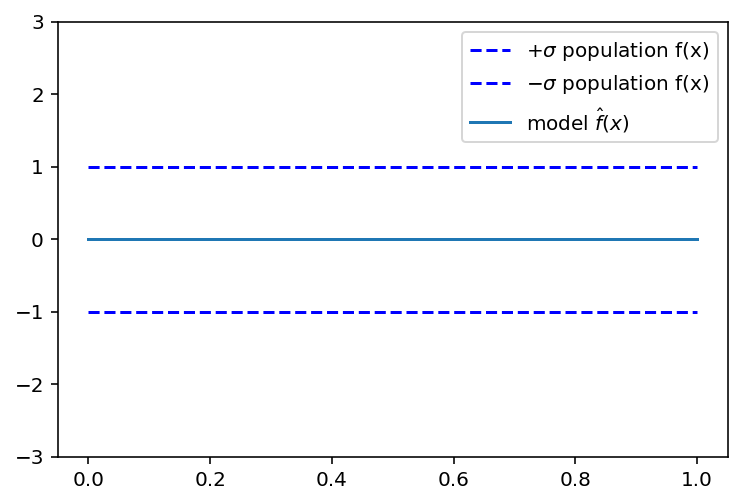

In [24]:
x = np.linspace(0,1,num=200)
f = np.ones_like(x)*1
plt.plot(x,np.zeros_like(x)+1, "b--", label="$+\sigma$ population f(x)")
plt.plot(x,np.zeros_like(x)-1, "b--", label="$-\sigma$ population f(x)")
plt.plot(x,np.zeros_like(x), label="model $\hat{f}(x)$")
plt.ylim(-3,3)
plt.legend()

* The bias is 0, because the expected value of the noise is 0 and the model are both 0.
* the variance is 0, because the model never changes as a result of new data.
* The irreducible noise is 1, because that is the variance of the noise in the data.
* The square error is `0+0+1`, which is the best possible model for this population.

## A more complicated example

Let's dive in deeper. Imagine a population described by:

$$f(x) = x^3 + 10x^2 + N(\sigma=50)$$

Text(0.5, 1.0, 'The smooth contours of the infinite world')

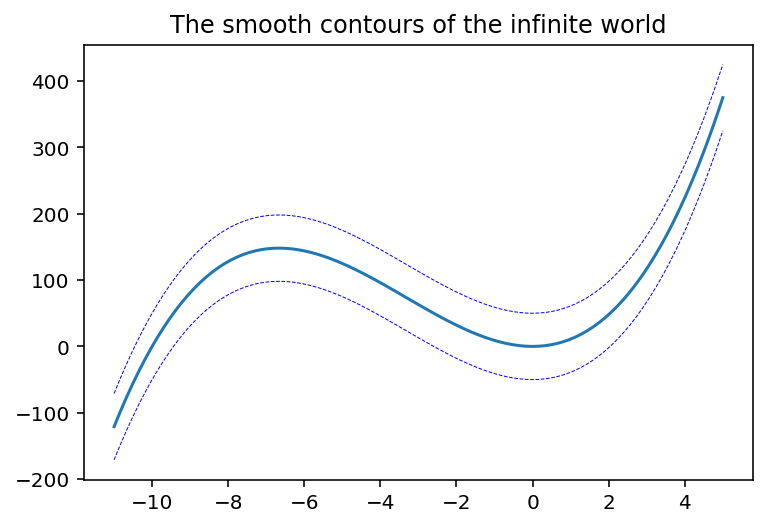

In [25]:
x = np.linspace(-11,5, num=100)
y = x**3 + 10*x**2
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)
plt.title("The smooth contours of the infinite world")

Of course we never get to see the population; all we get are samples.

I also want to call attention to an arbitrary point along the x axis.

In [26]:
def world_mean(x):
    return x**3 + 10*x**2

def sample_world(n):
    x = np.random.uniform(-11,5, size=n)
    y = world_mean(x) + np.random.normal(loc=0, scale=50, size=n)
    
    return np.stack([x,y])

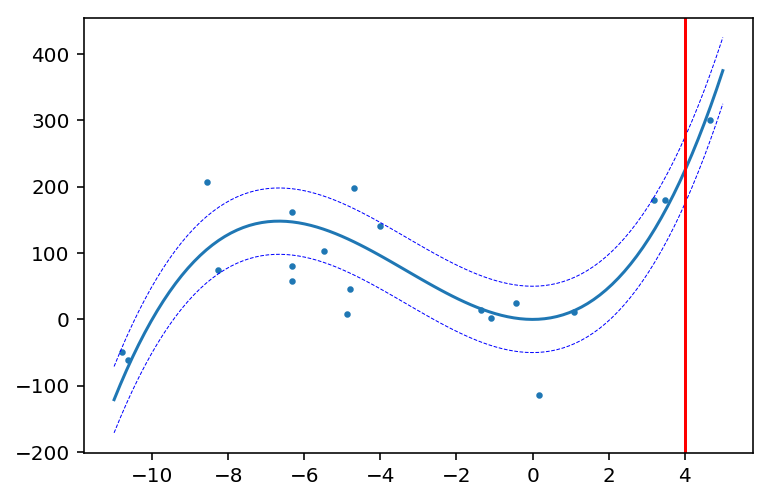

In [27]:
n_samples = 20
x0,y0 = sample_world(n_samples)
plt.scatter(x0,y0, s=5)

x = np.linspace(-11,5, num=100)
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)
plt.axvline(4, c="red")

Let's start a with a **very simple model**:

$$\hat{f}(x) = \beta$$.

We'll "train" this model by setting $\beta=E[y_0]$

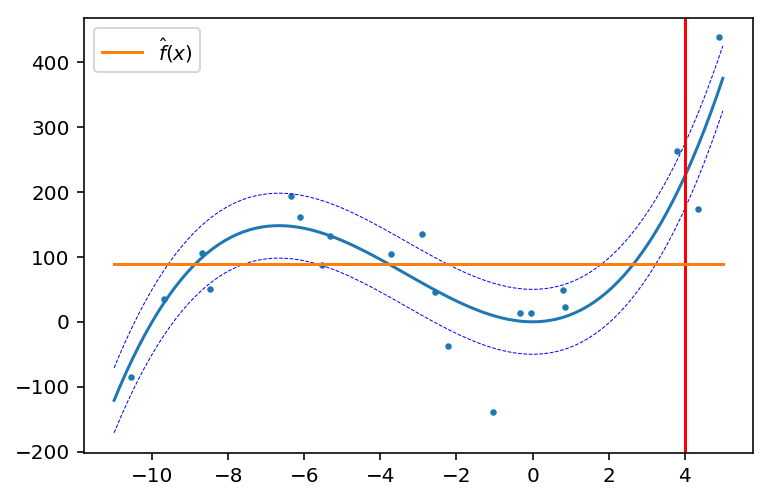

In [28]:



x0,y0 = sample_world(n_samples)
plt.scatter(x0,y0, s=5)

x = np.linspace(-11,5, num=100)
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)
plt.axvline(4, c="red")

beta = y0.mean()
plt.plot(x, np.ones_like(x)*beta, label="$\hat{f}(x)$")
plt.legend()

For the one arbitrary spot $x=4$, this model is wrong - we can read the difference off of the graph. It's off by:

In [29]:
world_mean(4) - beta

135.71143886489713

But that's not the bias; it's just a *sample* from a population of bias draws. To get a better estimate of the bias for this point, we need to re-train the model repeatedly and build up a larger sample of bias samples. Let's retrain the "model" 100 times, and plot them all on the same pane:

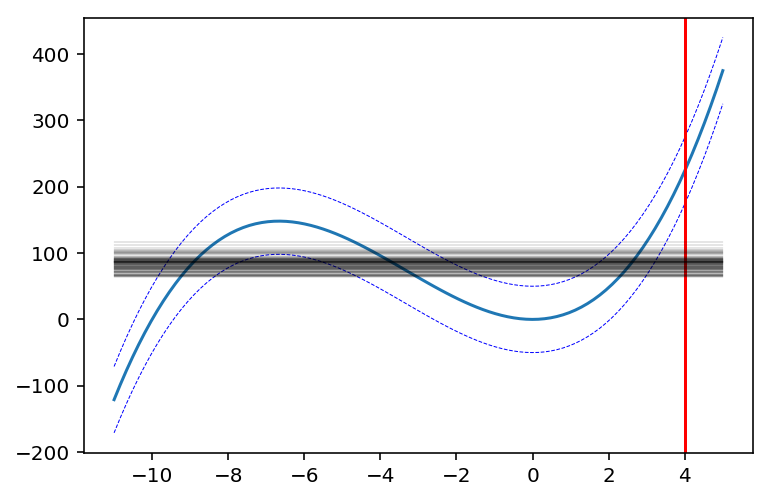

In [30]:
x = np.linspace(-11,5, num=100)
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)
plt.axvline(4, c="red")

betas = []
for i in range(100):
    x0,y0 = sample_world(100)
    beta = y0.mean()
    betas.append(beta)
    plt.plot(x, np.ones_like(x)*beta, c="black", lw=0.1)
betas = np.array(betas)

The prediction $\hat{f}(4)$ for all these different models is:

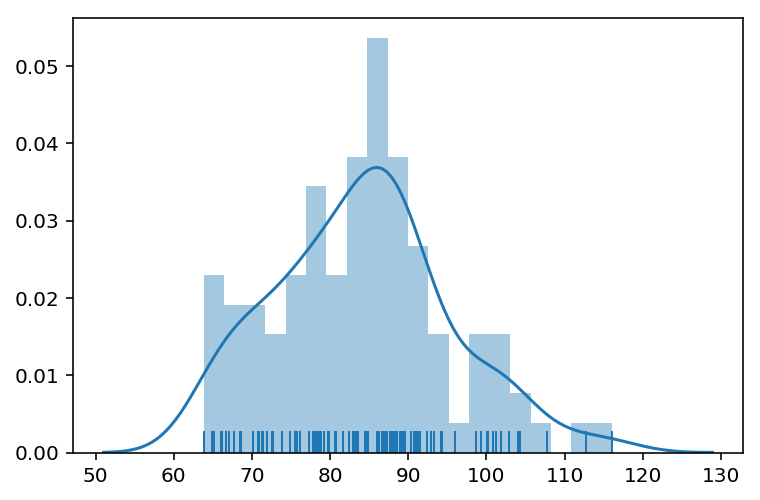

In [31]:
sns.distplot(betas, bins=20, rug=True)

From this we can estimate the bias $Bias(f(x)) = E[\hat{f}(x)] - f(x)$.

In [32]:
bias = betas.mean() - world_mean(4)
bias

-139.90566078590533

And also the error due to variance $Var(\hat{f}(x))$

In [33]:
betas.var()

122.82002838280226

Here's the mean square error of our model at x=4:

In [34]:
((betas-world_mean(4))**2).mean()

19696.413948323607

And here's the square bias plus variance of our model at x=4.

In [35]:
bias**2 + betas.var()

19696.413948323607

Cool, huh?

In a similar way we could estimate the bias and variance of the model along a space of points on the x axis.

Text(0.5, 1.0, 'Variance')

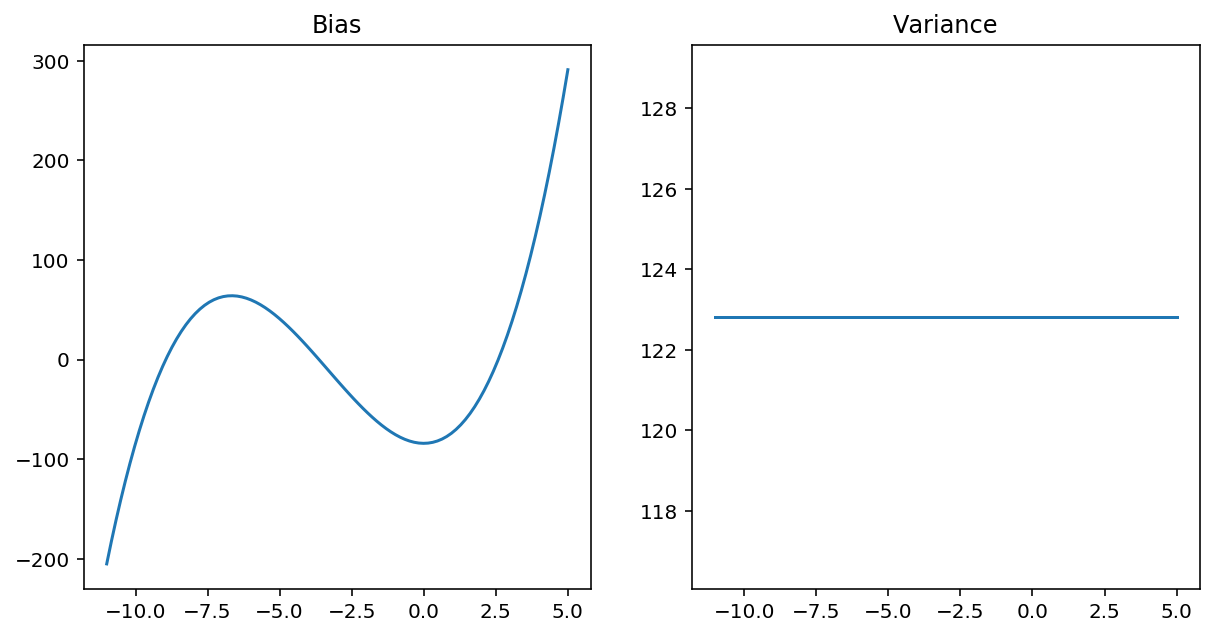

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y - betas.mean())
ax[0].set_title("Bias")
ax[1].plot(x, np.ones_like(x)*betas.var())
ax[1].set_title("Variance")

Finally we can take the integral of both curves.

In [37]:
beta0_bias_square = ((y - betas.mean())**2).sum()
beta0_variance = (np.ones_like(x)*betas.var()).sum()

beta0_bias_square, beta0_variance

(756336.3847051591, 12282.002838280232)

In [38]:
((y - betas.reshape((-1,1)) )**2).mean(axis=0).sum()

768618.3875434395

In [39]:
beta0_bias_square+beta0_variance

768618.3875434394

### Moar complexity

This $f(x) = \beta$ "model" is real dumb. We just learned about linear models. Let's use one of those.

$$\hat{f}(x) = \beta_0 + \beta_1 x$$

In [40]:
from sklearn.linear_model import LinearRegression

Get a sampleset of n=100 and train a linear model, 100 times.

In [41]:
x = np.linspace(-11,5, num=100)

In [42]:
betas = []
m = 100
fitlines = np.zeros((m,100))

for i in range(m):
    x0, y0 = sample_world(n_samples)
    X0 = np.stack([x0]).T

    model = LinearRegression()
    model.fit(X0,y0)
    
    fitline = model.intercept_ + model.coef_[0]*x
    fitlines[i] = fitline

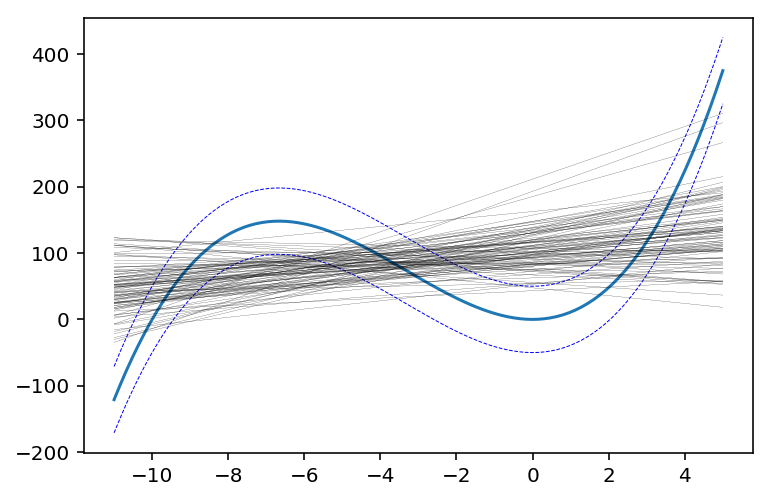

In [43]:

y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)

for fitline in fitlines:
    plt.plot(x, fitline, c="black", lw=0.1)

Text(0.5, 1.0, 'Variance')

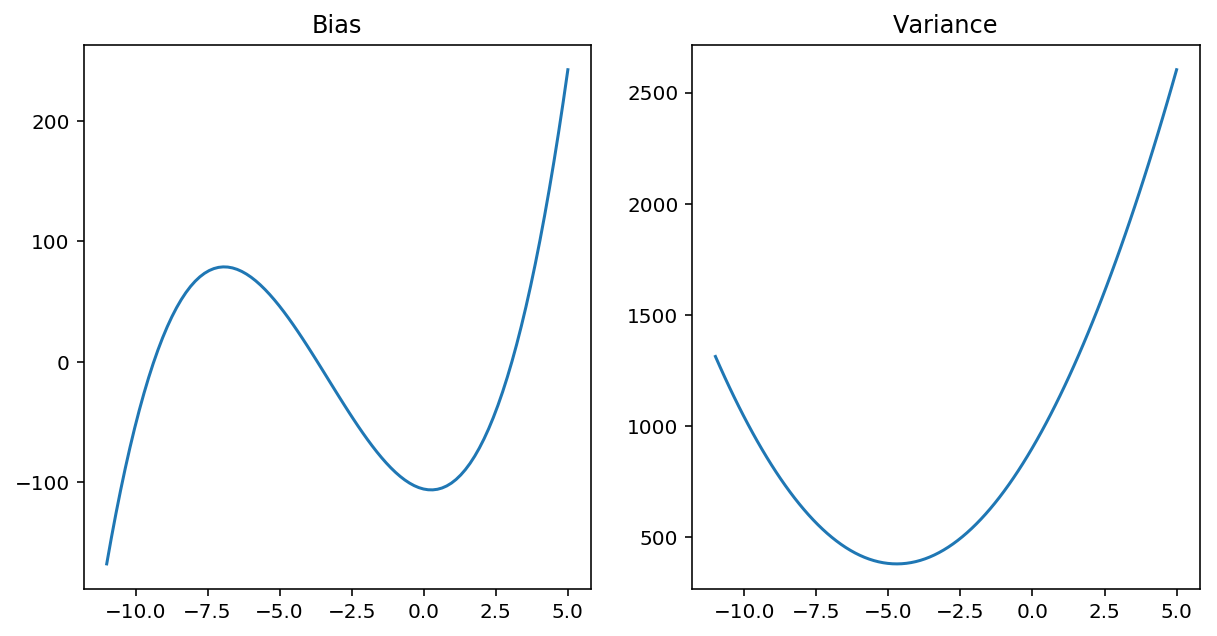

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
bias = y - fitlines.mean(axis=0)
variance = fitlines.var(axis=0)
ax[0].plot(x, bias )
ax[0].set_title("Bias")
ax[1].plot(x, variance)
ax[1].set_title("Variance")

In [45]:
beta1_bias_square = (bias**2).sum()
beta1_variance = variance.sum()

beta1_bias_square, beta1_variance


(677304.2154216592, 96260.04150464098)

In [46]:
beta1_bias_square + beta1_variance

773564.2569263001

Behold! Our reducible error `bias^2 + variance` is about the same, while our bias dropped and our variance rose.

### Moar complexity

The linear model is dumb too. How about a quadratic model?

$$\hat{f}(x) = \beta_0 + \beta_1 x + \beta_2 x^2$$

In [47]:
x = np.linspace(-11,5, num=100)

In [48]:
m = 100
fitlines = np.zeros((m,100))

for i in range(m):
    x0, y0 = sample_world(n_samples)
    X0 = np.stack([x0,x0**2]).T

    model = LinearRegression()
    model.fit(X0,y0)
    
    fitline = model.intercept_ + model.coef_[0]*x + model.coef_[1]*x**2
    fitlines[i] = fitline

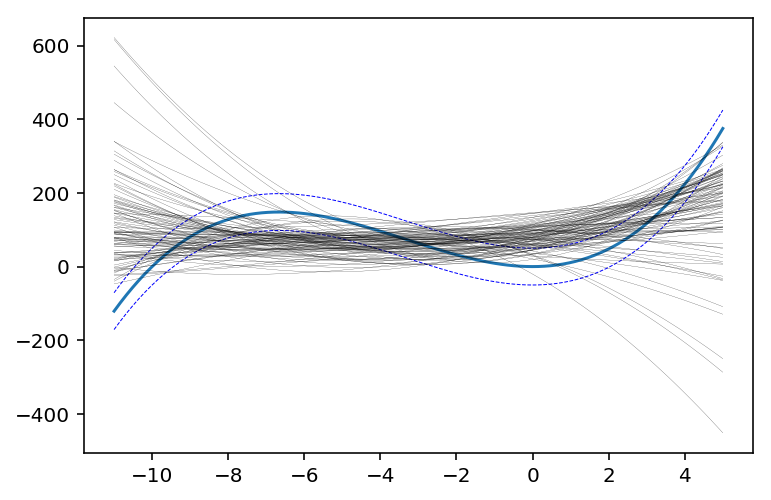

In [49]:
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)

for fitline in fitlines:
    plt.plot(x, fitline, c="black", lw=0.1)

Text(0.5, 1.0, 'Variance')

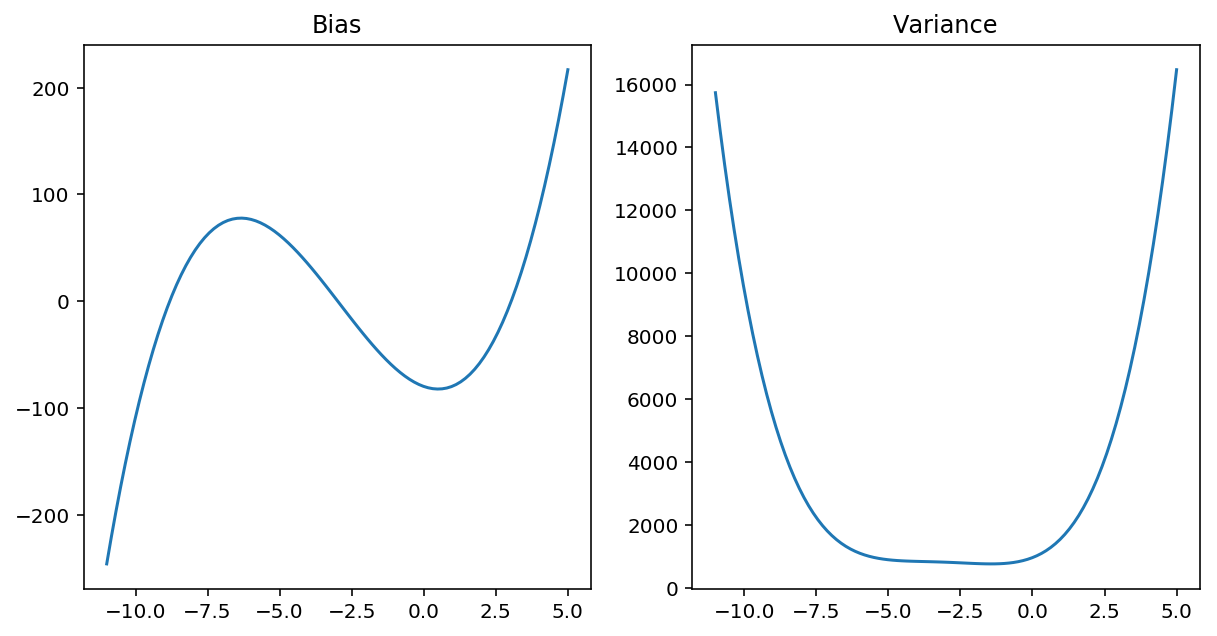

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
bias = y - fitlines.mean(axis=0)
variance = fitlines.var(axis=0)
ax[0].plot(x, bias )
ax[0].set_title("Bias")
ax[1].plot(x, variance)
ax[1].set_title("Variance")

In [51]:
beta2_bias_square = (bias**2).sum()
beta2_variance = variance.sum()

beta2_bias_square, beta1_variance

(676215.6518405176, 96260.04150464098)

In [52]:
beta2_bias_square + beta2_variance

1067066.720109404

Getting even worse.

### Now cubic

$$\hat{f}(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$$

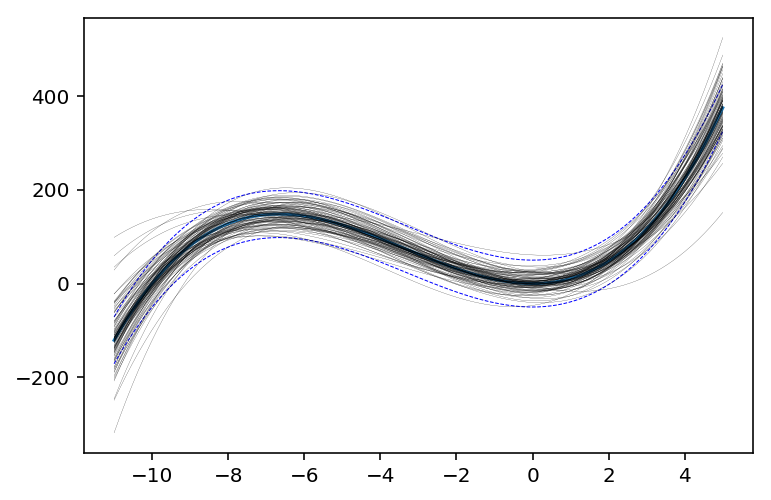

In [53]:
x = np.linspace(-11,5, num=100)

m = 100
fitlines = np.zeros((m,100))

for i in range(m):
    x0, y0 = sample_world(n_samples)
    X0 = np.stack([x0,x0**2,x0**3]).T

    model = LinearRegression()
    model.fit(X0,y0)
    
    fitline = model.intercept_ + model.coef_[0]*x + model.coef_[1]*x**2 + model.coef_[2]*x**3
    fitlines[i] = fitline
    
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)

for fitline in fitlines:
    plt.plot(x, fitline, c="black", lw=0.1)

Text(0.5, 1.0, 'Variance')

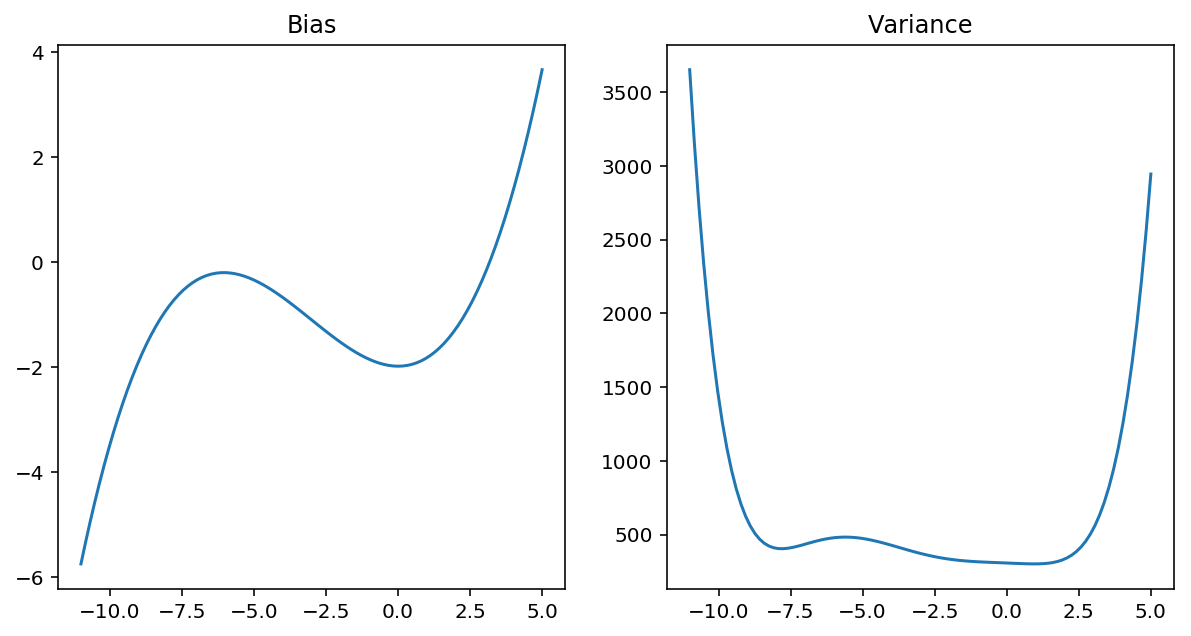

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
bias = y - fitlines.mean(axis=0)
variance = fitlines.var(axis=0)
ax[0].plot(x, bias )
ax[0].set_title("Bias")
ax[1].plot(x, variance)
ax[1].set_title("Variance")

In [55]:
beta3_bias_square = (bias**2).sum()
beta3_variance = variance.sum()

beta3_bias_square, beta3_variance

(359.127016278748, 70097.44429605147)

In [56]:
beta3_bias_square + beta3_variance

70456.57131233023

## Now hypercubic

$$\hat{f}(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$$

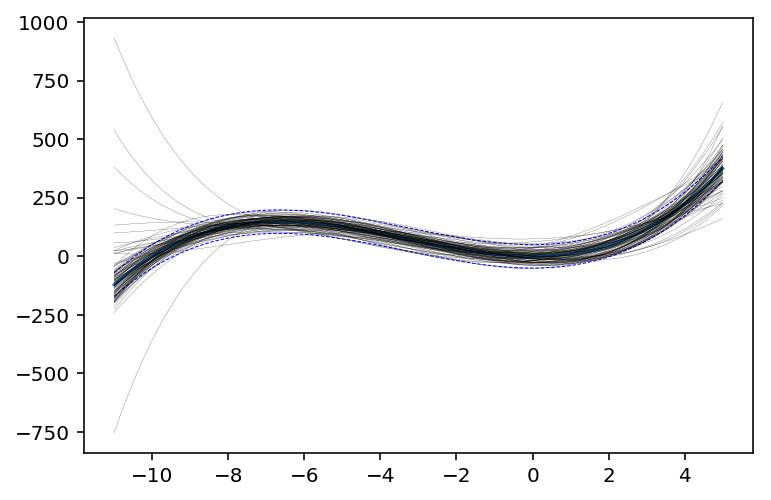

In [57]:
x = np.linspace(-11,5, num=100)

m = 100
fitlines = np.zeros((m,100))

for i in range(m):
    x0, y0 = sample_world(n_samples)
    X0 = np.stack([x0,x0**2,x0**3,x0**4]).T

    model = LinearRegression()
    model.fit(X0,y0)
    
    fitline = model.intercept_ + model.coef_[0]*x + model.coef_[1]*x**2 + model.coef_[2]*x**3 + model.coef_[3]*x**4
    fitlines[i] = fitline
    
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)

for fitline in fitlines:
    plt.plot(x, fitline, c="black", lw=0.1)

Text(0.5, 1.0, 'Variance')

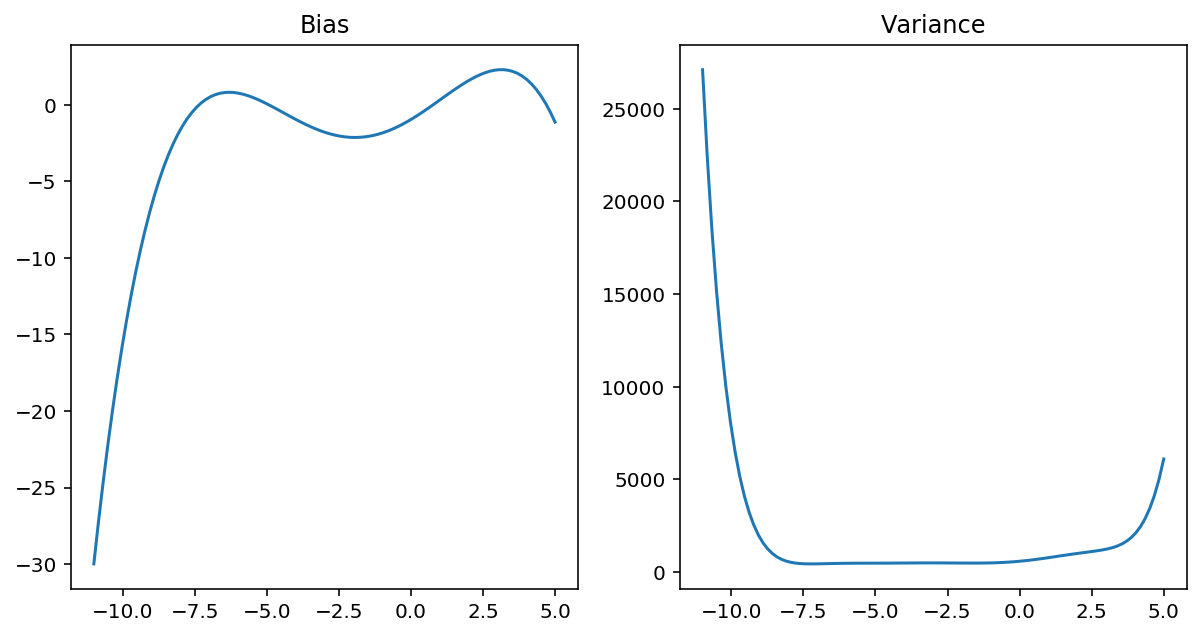

In [58]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
bias = y - fitlines.mean(axis=0)
variance = fitlines.var(axis=0)
ax[0].plot(x, bias )
ax[0].set_title("Bias")
ax[1].plot(x, variance)
ax[1].set_title("Variance")

In [59]:
beta4_bias_square = (bias**2).sum()
beta4_variance = variance.sum()

beta4_bias_square, beta4_variance

(4646.284565715532, 218343.61220085964)

In [60]:
beta3_bias_square + beta3_variance

70456.57131233023

## Now metahypercubic

$$\hat{f}(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 + \beta_5 x^5$$

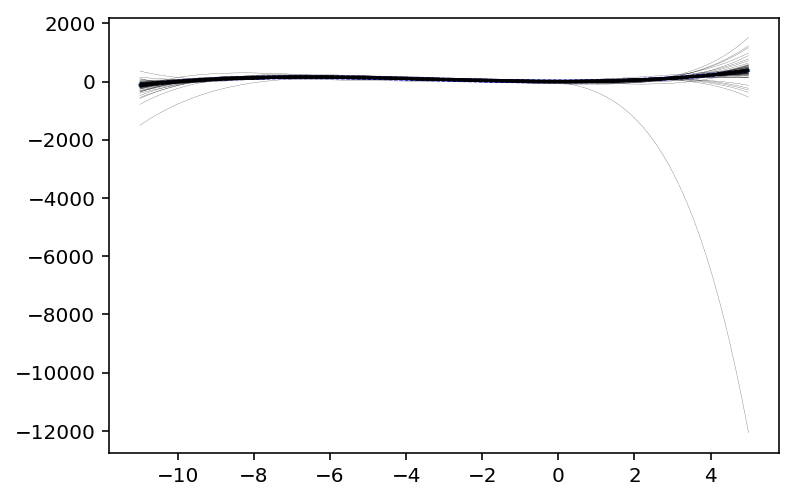

In [61]:
x = np.linspace(-11,5, num=100)

m = 100
fitlines = np.zeros((m,100))

for i in range(m):
    x0, y0 = sample_world(n_samples)
    X0 = np.stack([x0,x0**2,x0**3,x0**4,x0**5]).T

    model = LinearRegression()
    model.fit(X0,y0)
    
    fitline = model.intercept_ + model.coef_[0]*x + model.coef_[1]*x**2 + model.coef_[2]*x**3 + \
              model.coef_[3]*x**4 + model.coef_[4]*x**5
    fitlines[i] = fitline
    
y = world_mean(x)
sigma = 50
plt.plot(x,y)
plt.plot(x,y+sigma, "b--", lw=0.5)
plt.plot(x,y-sigma, "b--", lw=0.5)

for fitline in fitlines:
    plt.plot(x, fitline, c="black", lw=0.1)

Text(0.5, 1.0, 'Variance')

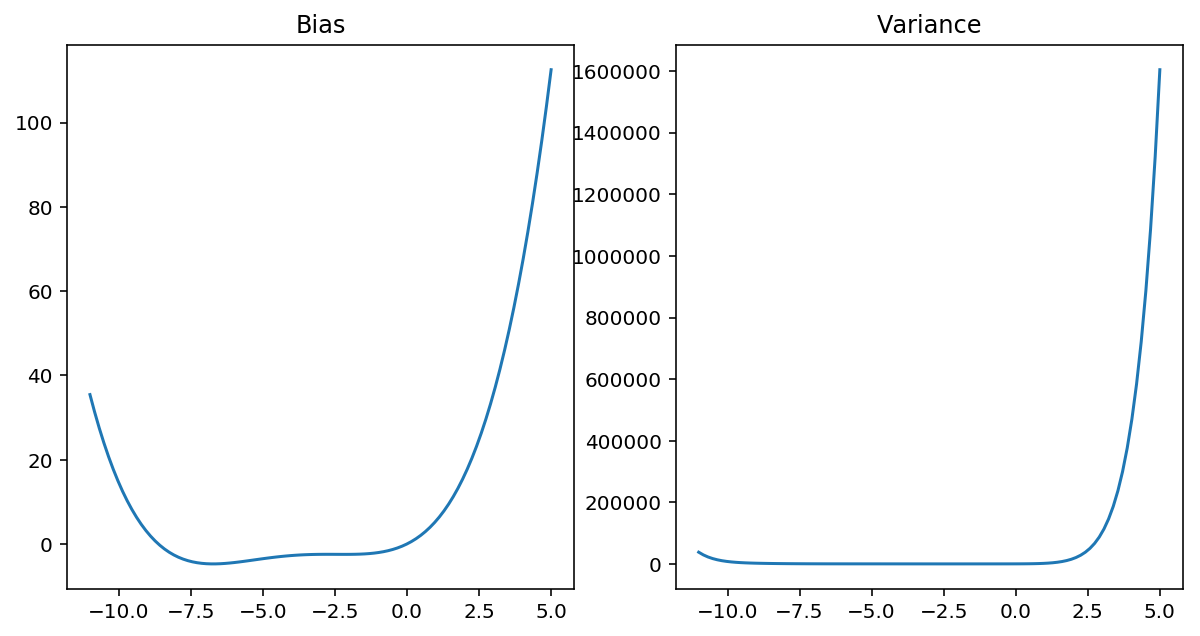

In [62]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
bias = y - fitlines.mean(axis=0)
variance = fitlines.var(axis=0)
ax[0].plot(x, bias )
ax[0].set_title("Bias")
ax[1].plot(x, variance)
ax[1].set_title("Variance")

In [63]:
beta5_bias_square = (bias**2).sum()
beta5_variance = variance.sum()

beta5_bias_square, beta5_variance

(81921.22895694572, 8604249.548855279)

In [64]:
beta5_bias_square + beta5_variance

8686170.777812224

## The Bias-Variance Tradeoff

(0, 2000000.0)

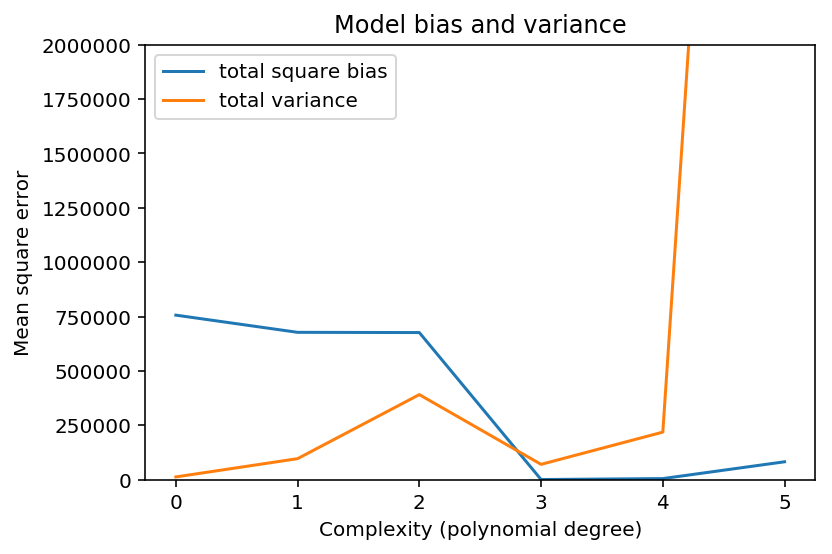

In [65]:
degree = [0,1,2,3,4,5]
bias_square_trace = np.array([beta0_bias_square, beta1_bias_square,
                    beta2_bias_square, beta3_bias_square,
                    beta4_bias_square, beta5_bias_square])
variance_trace = np.array([beta0_variance, beta1_variance,
                  beta2_variance, beta3_variance,
                  beta4_variance, beta5_variance])

plt.plot( degree, bias_square_trace, label="total square bias")
plt.plot( degree, variance_trace, label="total variance")
plt.xlabel("Complexity (polynomial degree)")
plt.ylabel("Mean square error")
plt.title("Model bias and variance")
plt.legend()
plt.ylim(0, 0.2e7)

Text(0, 0.5, 'Model mean square error')

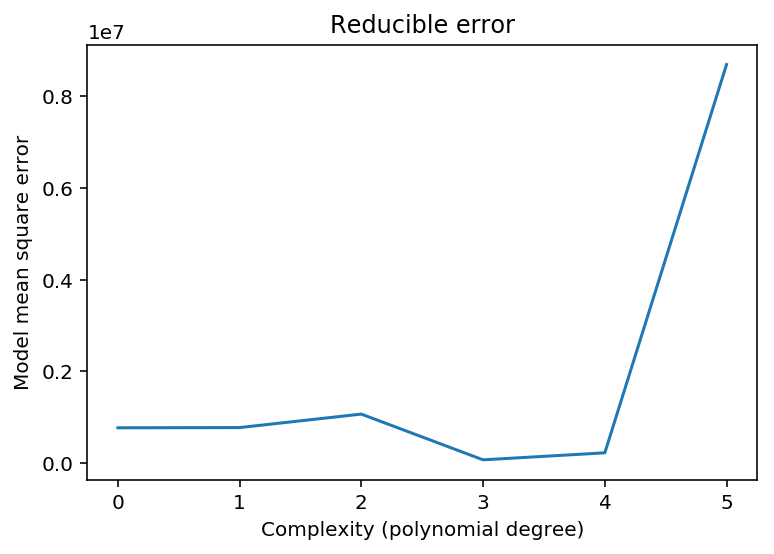

In [66]:
plt.plot(degree, bias_square_trace+variance_trace)
plt.title("Reducible error")
plt.xlabel("Complexity (polynomial degree)")
plt.ylabel("Model mean square error")

As model complexity increases:
* Bias decreases as the model is able to fit complex curves more slowly.
* Variance increases as the model reacts strongly to different training sets.

This tradeoff is a **fundamental law of nature**. It's called the bias-variance tradeoff, and because the part of the error that *we* have control over is a sum of the square bias and variance, this means that we **cannot increase model complexity indefinitely to get constantly increasing performance**.

This bonkers law of nature has the following amazing consequence:

**For any given machine learning prediction task, the ideal model has some unknown optimal level of complexity.**

### Underfitting and overfitting

Choosing too little complexity, resulting in a model without the ductility to represent your data, is called **underfitting**.

Choosing too much complexity, resulting in a model flexible enough to capture the noise in your population is called **overfitting**.


In [67]:
np.random.seed(33)
x0, y0 = sample_world(20)

Text(0.5, 1.0, 'degree 9: overfit')

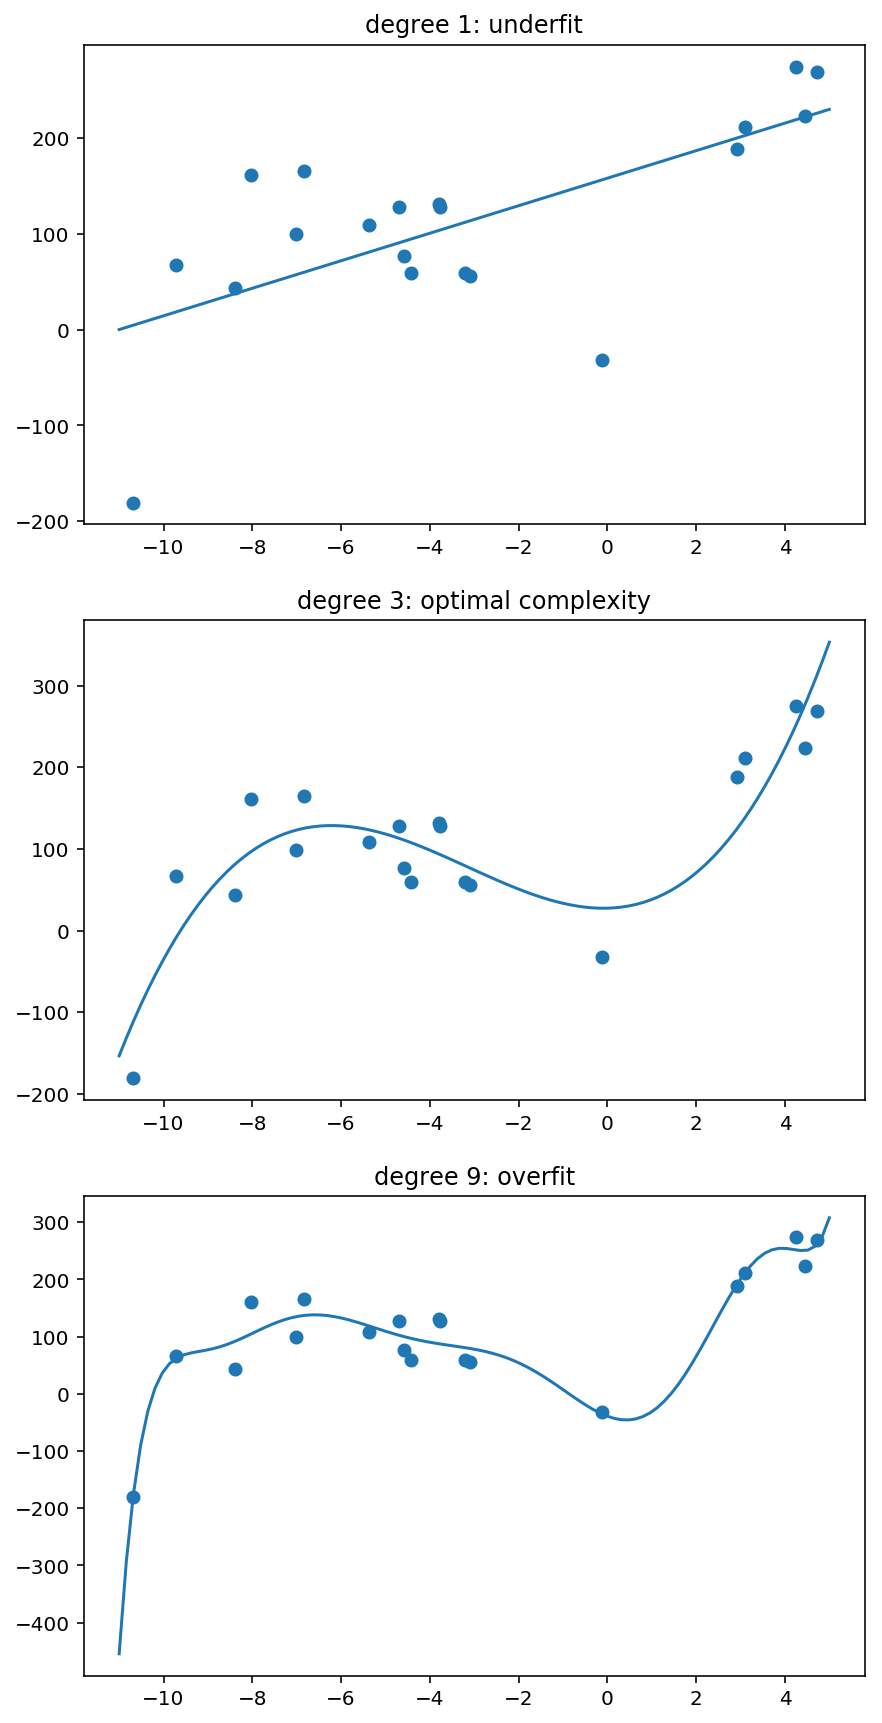

In [68]:
fig, ax = plt.subplots(3,1, figsize=(7,15))

model = LinearRegression()
model.fit(np.stack([x0]).T,y0)

x = np.linspace(-11,5,100)
X = np.stack([x]).T

ax[0].scatter(x0,y0)
ax[0].plot(x, model.predict(X))
ax[0].set_title("degree 1: underfit")

#=====
model = LinearRegression()
model.fit(np.stack([x0,x0**2,x0**3]).T,y0)

x = np.linspace(-11,5,100)
X = np.stack([x,x**2,x**3]).T

ax[1].scatter(x0,y0)
ax[1].plot(x, model.predict(X))
ax[1].set_title("degree 3: optimal complexity")
#=====
model = LinearRegression()
model.fit(np.stack([x0,x0**2,x0**3,x0**4,x0**5,x0**6,x0**7,x0**8,x0**9]).T,y0)

x = np.linspace(-11,5,100)
X = np.stack([x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T

ax[2].scatter(x0,y0)
ax[2].plot(x, model.predict(X))
ax[2].set_title("degree 9: overfit")
